In [1]:
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta
from torch.distributions.normal import Normal

import pickle
from utils import *
import torch.utils.data as data

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

/home/quan1691996/normalization_flow_basis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download dataset

In [2]:
FILENAME = 'shape.pkl'
with open(FILENAME, 'rb') as f:
    shape_data = pickle.load(f)
training_data, testing_data = shape_data['train'], shape_data['test']
# training_data.shape = (10479, 20, 20, 1)
training_data = (training_data > 127.5).astype(np.uint8)
# training_data.shape = (4491, 20, 20, 1)
testing_data = (testing_data > 127.5).astype(np.uint8)

train_loader = data.DataLoader(ShapesDataset(training_data), shuffle=True, batch_size=128)
test_loader = data.DataLoader(ShapesDataset(testing_data), shuffle=True, batch_size=128)

Training

In [3]:
flow = AutoRegressiveFlow(1, num_layers=5, n_components=10)
flow.apply(weights_init)

AutoRegressiveFlow(
  (model): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (13): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (14): ReLU()
    (15): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (16): MaskedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (17): 

In [4]:
device = torch.device("cpu")

def train_and_eval(flow, epochs, lr, train_loader, test_loader, target_distribution):
    print('no of parameters is', sum(param.numel() for param in flow.parameters()))
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        print('Starting epoch:', epoch+1, 'of', epochs)
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses

target_distribution = Uniform(torch.tensor(0).float().to(device),torch.tensor(1).float().to(device))
flow, train_losses, test_losses = train_and_eval(flow, 20, 1e-3, train_loader, test_loader, target_distribution)
print('train losses are', train_losses)
print('test losses are', test_losses)

no of parameters is 1013790
Starting epoch: 1 of 20
Starting epoch: 2 of 20
Starting epoch: 3 of 20
Starting epoch: 4 of 20
Starting epoch: 5 of 20
Starting epoch: 6 of 20
Starting epoch: 7 of 20
Starting epoch: 8 of 20
Starting epoch: 9 of 20
Starting epoch: 10 of 20
Starting epoch: 11 of 20
Starting epoch: 12 of 20
Starting epoch: 13 of 20
Starting epoch: 14 of 20
Starting epoch: 15 of 20
Starting epoch: 16 of 20
Starting epoch: 17 of 20
Starting epoch: 18 of 20
Starting epoch: 19 of 20
Starting epoch: 20 of 20
train losses are [3.6255643367767334, 0.4485270380973816, 2.6166441440582275, -0.2286633402109146, 0.5354202389717102, 2.7266104221343994, 2.367159843444824, -0.4934118986129761, -0.7398662567138672, 0.6573632955551147, 0.4051560163497925, -0.08430743962526321, 1.9238247871398926, -0.7301827669143677, -0.10257623344659805, -0.7886518836021423, -0.8365925550460815, 1.2056536674499512, -0.6689359545707703, -1.1547787189483643]
test losses are [3.625563621520996, 0.44837987422943

In [6]:
def sample(flow, num_samples):
    n_channels, height, width = 1, 20, 20
    result = torch.zeros(num_samples, n_channels, height, width)
    with torch.no_grad():
        for row in range(height):
            for col in range(width):
                for channel in range(n_channels):
                    model_output = flow.model(result)
                    mus, log_sigmas, weight_logits = torch.chunk(model_output, 3, dim=1)
                    
                    mus = mus.view(num_samples, flow.n_components, n_channels, height, width)
                    log_sigmas = log_sigmas.view(num_samples, flow.n_components, n_channels, height, width)
                    weight_logits = weight_logits.view(num_samples, flow.n_components, n_channels, height, width)
                    
                    # get the mus, sigmas and weights for pixel at (channel, row, col)
                    mus = mus[:,:,channel, row, col]
                    log_sigmas = log_sigmas[:,:,channel, row, col]
                    weight_logits = weight_logits[:,:,channel, row, col]
                    weights = weight_logits.softmax(dim=1)
                    
                    # a sample at (channel, row, col) comes from a mixture of Gaussians
                    # where the probability of the Gaussian `i` is given by `weights[i]`
                    indices_of_gaussians_to_sample_from = torch.multinomial(weights, 1).squeeze(-1)
                    zero_to_num_samples = torch.arange(num_samples)
                    mus_per_batch = mus[zero_to_num_samples, indices_of_gaussians_to_sample_from]
                    sigmas_per_batch = log_sigmas[zero_to_num_samples, indices_of_gaussians_to_sample_from].exp()
                    result[:, channel, row, col] = torch.normal(mus_per_batch, sigmas_per_batch)
    return result

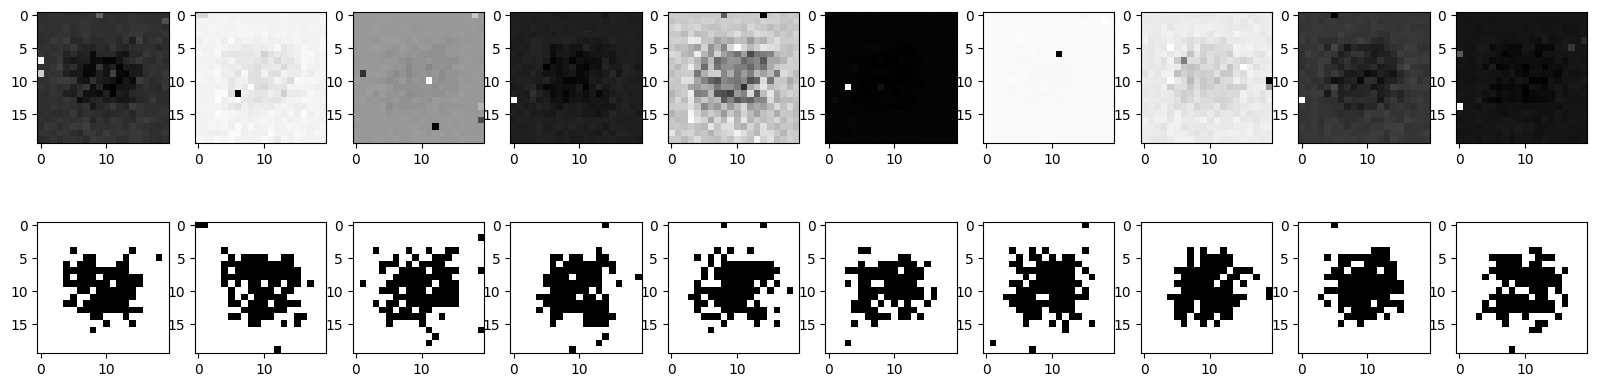

In [7]:
out = sample(flow, 10)
_, axes = plt.subplots(2,10,figsize=(20,5))

for i in range(10):
    _ = axes[0][i].imshow((out[i].squeeze().numpy()).astype(np.float32) , 'gray')
    _ = axes[1][i].imshow((out[i].squeeze().numpy()).astype(np.float32) > 0.375 , 'gray')